In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from scipy.stats import sem
from sklearn.utils import resample
from sklearn import preprocessing
import warnings
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,plot_roc_curve
warnings.filterwarnings("ignore")
%matplotlib inline

### Cull the empty data and irrelevant data columns

In [11]:
train_data = pd.read_csv("train.csv")
train_data = train_data.replace('?', np.nan)

def about_data(df):
    total_missing_values = df.isnull().sum().reset_index()
    total_missing_values = total_missing_values.rename(columns={'index':'columns',0:'total missing'})
    total_missing_values['ration of missing'] = total_missing_values['total missing']/len(df)
    return total_missing_values
#There are 3 columns have null value. we can drop it because of percentage of missing value very low
train_data.dropna(inplace=True,axis=0)

about_data(train_data)

,columns,total missing,ration of missing
0,age,0,0.0
1,workclass,0,0.0
2,fnlwgt,0,0.0
3,education,0,0.0
4,educational-num,0,0.0
5,marital-status,0,0.0
6,occupation,0,0.0
7,relationship,0,0.0
8,race,0,0.0
9,gender,0,0.0


Correlation Matrix:
               Correlation Coefficient
workclass                     0.014578
education                     0.079821
marital-status               -0.192295
occupation                    0.049186
relationship                  -0.25348
race                           0.07048
gender                        0.215658
native-country                0.022573


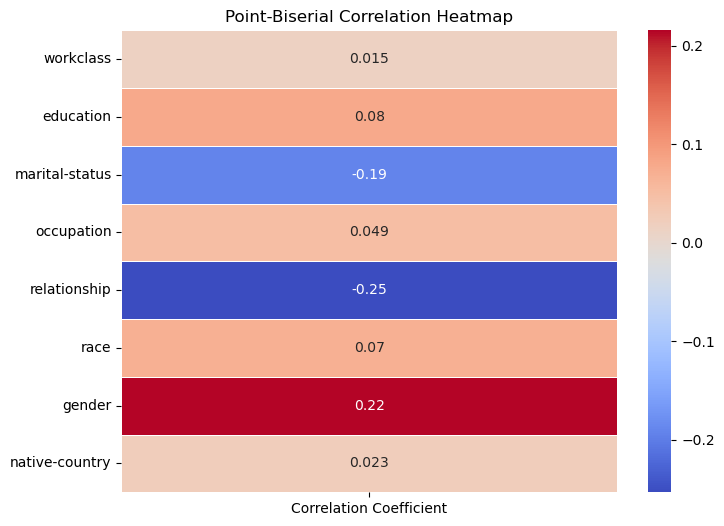

In [12]:

#list columns to drop
drop_columns = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

df = pd.DataFrame(train_data.drop(columns= drop_columns))

# List of categorical variables
categorical_vars = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

# Create an empty matrix to store correlation coefficients
correlation_matrix = pd.DataFrame(index=categorical_vars, columns=['Correlation Coefficient'])

# Iterate over categorical variables
for cat_var in categorical_vars:
    # Encode categorical variable if needed
    df[cat_var] = pd.Categorical(df[cat_var]).codes
    
    # Calculate point-biserial correlation coefficient
    correlation_coefficient, _ = pointbiserialr(df[cat_var], df['income_>50K'])
    
    # Store the result in the matrix
    correlation_matrix.loc[cat_var, 'Correlation Coefficient'] = correlation_coefficient

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Point-Biserial Correlation Heatmap')
plt.show()


Correcting the imbalanced data

In [13]:
train, test = train_test_split(train_data, test_size=0.2, random_state=21)
scaled_X_train, y_train = train.drop(columns=['income_>50K']), train["income_>50K"]
scaled_X_test, y_test = test.drop(columns=['income_>50K']), test["income_>50K"]

scaled_X_train=scaler.fit_transform(scaled_X_train) #Scaling and fitting the training set to a model
scaled_X_test=scaler.transform(scaled_X_test)

NameError: name 'scaler' is not defined

Logistic Regression type model

In [15]:
trees = 100
max_features = 3
results = []
names_of_models = []

model_list = [('LR', LogisticRegression()),
             ('KNN', KNeighborsClassifier()),
             ('DTC', DecisionTreeClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=trees,max_features=3))]


for name, model in model_list:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, scaled_X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names_of_models.append(name)
    res = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
    print(res)

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

Retrain with tuned parameters

In [ ]:
parameters_for_testing = {
"n_estimators"    : [50,100,150,200,250] ,
 "max_features"        : [1,2,3,4,5],
}
model = RandomForestClassifier()

kfold = KFold(n_splits=10, random_state=42)
grid_cv = GridSearchCV(estimator=model, param_grid=parameters_for_testing, scoring='accuracy', cv=kfold)
result = grid_cv.fit(scaled_X_train, y_train)

print("Best: {} using {}".format(result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{}  {} with: {}" .format(mean, stdev, param))

In [ ]:
tuned_model_rf = RandomForestClassifier(n_estimators=150,max_features=5)
tuned_model_rf.fit(scaled_X_train, y_train)
predictions = tuned_model_rf.predict(scaled_X_test)